In [1]:
import json
import math

import numpy as np
import pandas as pd
from scapy.all import rdpcap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from PL_dataparser import PLDataParser
from IAT_dataparser import IATDataParser

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

/home/ce-intern/Desktop/network_time_prediction/network-pred/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [3]:
# data_path = "../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619005750_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"
# data_path = '../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619782605_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json'
data_path = "../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619192105_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"

# Instantiate DataParser class
pl_data_parser = PLDataParser(data_path)
iat_data_parser = IATDataParser(data_path)

# Reading the biflow data
biflow_data = pl_data_parser.biflow_data

biflows = list(biflow_data.keys())

print("biflows: ", biflows)
print('number of biflows: ', len(biflows))

biflows:  ['192.168.20.111,68,192.168.20.254,67,17', '192.168.20.111,51560,8.8.4.4,853,6', '192.168.20.111,46279,8.8.8.8,853,6', '192.168.20.111,55009,142.250.180.68,443,6', '192.168.20.111,55586,142.250.184.35,80,6', '192.168.20.111,51564,8.8.4.4,853,6', '192.168.20.111,40978,108.177.127.188,5228,6', '192.168.20.111,38155,142.250.184.36,443,17', '192.168.20.111,38544,142.250.184.36,443,6', '192.168.20.111,39646,172.217.21.67,443,6', '192.168.20.111,33755,142.250.184.42,443,6', '192.168.20.111,32786,216.58.205.74,443,6', '192.168.20.111,41662,216.58.206.42,443,6', '192.168.20.111,41663,216.58.206.42,443,6', '192.168.20.111,41513,216.58.198.46,443,6', '192.168.20.111,41515,216.58.198.46,443,6', '192.168.20.111,37742,142.250.180.74,443,17', '192.168.20.111,57411,142.250.180.74,443,17', '192.168.20.111,36736,142.250.180.74,443,6', '192.168.20.111,36737,142.250.180.74,443,6', '192.168.20.111,51073,216.58.198.42,443,17', '192.168.20.111,58540,216.58.198.42,443,6', '192.168.20.111,50145,216.

In [4]:
test_PL = pl_data_parser.generate_debug_set()
test_PL = pl_data_parser.saturate_99(test_PL)
test_PL = pl_data_parser.minmax_scaler(test_PL)

test_IAT = iat_data_parser.generate_debug_set()
test_IAT = iat_data_parser.saturate_99(test_IAT)
test_IAT = iat_data_parser.minmax_scaler(test_IAT)

# all_PL = pl_data_parser.aggregate_PL()
# all_PL = pl_data_parser.saturate_99(all_PL)
# all_PL = pl_data_parser.minmax_scaler(all_PL)

# all_IAT = iat_data_parser.aggregate_IAT()
# all_IAT = iat_data_parser.saturate_99(all_IAT)
# all_IAT = iat_data_parser.minmax_scaler(all_IAT)


# len(test_PL)
# data_parser.plotPL(test_PL)

# display(all_PL)
# display(all_IAT)

In [5]:
# DEFINE WINDOWS AND BATCH SIZE HERE
memory_window = 63
prediction_window = 1
batch_size = 32


pl_memory_window_set, pl_gd_truth_set = pl_data_parser.create_sequences(
    test_PL['PL_scaled'], memory_window, prediction_window)  # Splitting data into memory_window and prediction_window (ground truth)

iat_memory_window_set, iat_gd_truth_set = iat_data_parser.create_sequences(
    test_IAT['Interarrival_scaled'], memory_window, prediction_window)  # Splitting data into memory_window and prediction_window (ground truth)

# pl_memory_window_set, pl_gd_truth_set = pl_data_parser.create_sequences(
#     all_PL['PL_scaled'], memory_window, prediction_window)  # Splitting data into memory_window and prediction_window (ground truth)

# iat_memory_window_set, iat_gd_truth_set = iat_data_parser.create_sequences(
#     all_IAT['Interarrival_scaled'], memory_window, prediction_window)  # Splitting data into memory_window and prediction_window (ground truth)

# display(memory_window_set)
print("length of input IAT data: ", len(test_IAT['Interarrival_scaled']))
print("length of input PL data: ", len(test_PL['PL_scaled']))
print(
    f"PL Input shape: {pl_memory_window_set.shape}, Output shape: {pl_gd_truth_set.shape}")
print(
    f"IAT Input shape: {iat_memory_window_set.shape}, Output shape: {iat_gd_truth_set.shape}")

print("pl data: ", pl_memory_window_set)
print("iat data: ", iat_memory_window_set)

length of input IAT data:  1314
length of input PL data:  1314
PL Input shape: (1251, 63), Output shape: (1251, 1)
IAT Input shape: (1251, 63), Output shape: (1251, 1)
pl data:  [[0.4885565  0.70652787 0.75162539 ... 0.19918073 0.00751625 0.51862152]
 [0.70652787 0.75162539 0.70652787 ... 0.00751625 0.51862152 0.13529257]
 [0.75162539 0.70652787 0.75162539 ... 0.51862152 0.13529257 1.        ]
 ...
 [0.21045511 0.41715209 0.26682701 ... 0.18039009 0.18039009 0.20293886]
 [0.41715209 0.26682701 0.21421324 ... 0.18039009 0.20293886 0.10146943]
 [0.26682701 0.21421324 0.00751625 ... 0.20293886 0.10146943 0.38332895]]
iat data:  [[0.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.81156597e-02
  1.17756319e-01 4.52846179e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.17756319e-01
  4.52846179e-02 1.35871979e-01]
 [1.00000000e+00 1.00000000e+00 9.42494607e-01 ... 4.52846179e-02
  1.35871979e-01 1.48767718e-01]
 ...
 [2.08316492e-01 1.17765381e-01 3.80401666e-01 ... 1.35853854e-01

In [6]:
# Stack the arrays along the third axis (axis=2)
merged_inputs = np.stack((iat_memory_window_set, pl_memory_window_set), axis=-1)
merged_inputs = merged_inputs.transpose(0, 2, 1)

train_size = int(len(merged_inputs) * 0.8)
X_train, y_train = merged_inputs[:train_size], iat_gd_truth_set[:train_size]
X_test, y_test = merged_inputs[train_size:], iat_gd_truth_set[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

# print("x train shape: ", X_train.shape)
# print("x test shape: ", X_test.shape)
# print("y train shape: ", y_train.shape)
# print("y test shape: ", y_test.shape)

# for data, target in train_loader:
#     print("data shape: ", data.shape)
#     print("target shape: ", target.shape)

#     print("data: ", data)
#     print("target: ", target)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layer 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=32,
                      kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3)
        )

        # Convolutional layer 2
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64,
                      kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3)
        )

        self.out = nn.Linear(64 * 7, prediction_window)

    def forward(self, x):
        # print("Size of x: ", x.size())
        # x = x.unsqueeze(0).permute(1, 0, 2)
        # print("Size of x: ", x.size())
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [8]:
cnn = CNN()
print(cnn)
loss_func = nn.MSELoss()
print(loss_func)
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
print(optimizer)

CNN(
  (conv1): Sequential(
    (0): Conv1d(2, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=448, out_features=1, bias=True)
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [9]:
num_epochs = 100
# num_epochs = 1

# Function to calculate RMSE


def calculate_rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))


# Lists to store loss and RMSE
train_rmse_list = []
val_rmse_list = []
all_losses = []

# Training loop
for epoch in range(num_epochs):
    cnn.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        # print(X_batch.shape)
        optimizer.zero_grad()
        outputs = cnn(X_batch)[0]
        # y_batch = y_batch.squeeze(-1)
        # print("outputs size: ", outputs.size())
        # print("y_batch size: ", y_batch.size())
        loss = loss_func(outputs, y_batch)
        loss.backward()
        optimizer.step()

        all_losses.append(loss.item())
        train_losses.append(loss.item())

    # Calculate average training loss
    train_loss = np.mean(train_losses)

    # Calculate training RMSE
    train_rmse = calculate_rmse(
        outputs.detach().cpu().numpy(), y_batch.detach().cpu().numpy())
    train_rmse_list.append(train_rmse)

    # Print loss every 10 epochs
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [2/100], Loss: 0.0026
Epoch [4/100], Loss: 0.0026
Epoch [6/100], Loss: 0.0019
Epoch [8/100], Loss: 0.0018
Epoch [10/100], Loss: 0.0018
Epoch [12/100], Loss: 0.0018
Epoch [14/100], Loss: 0.0019
Epoch [16/100], Loss: 0.0018
Epoch [18/100], Loss: 0.0016
Epoch [20/100], Loss: 0.0023
Epoch [22/100], Loss: 0.0022
Epoch [24/100], Loss: 0.0016
Epoch [26/100], Loss: 0.0016
Epoch [28/100], Loss: 0.0014
Epoch [30/100], Loss: 0.0014
Epoch [32/100], Loss: 0.0013
Epoch [34/100], Loss: 0.0013
Epoch [36/100], Loss: 0.0016
Epoch [38/100], Loss: 0.0017
Epoch [40/100], Loss: 0.0018
Epoch [42/100], Loss: 0.0012
Epoch [44/100], Loss: 0.0009
Epoch [46/100], Loss: 0.0008
Epoch [48/100], Loss: 0.0006
Epoch [50/100], Loss: 0.0008
Epoch [52/100], Loss: 0.0007
Epoch [54/100], Loss: 0.0005
Epoch [56/100], Loss: 0.0004
Epoch [58/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0002
Epoch [62/100], Loss: 0.0002
Epoch [64/100], Loss: 0.0003
Epoch [66/100], Loss: 0.0002
Epoch [68/100], Loss: 0.0002
Epoch [70/100], Lo

Test RMSE: 0.0130


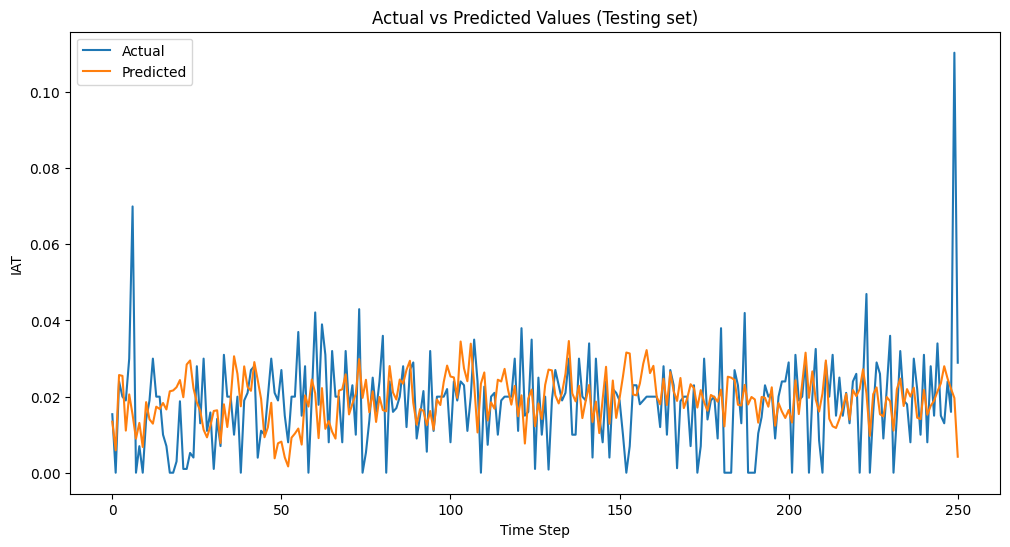

In [10]:
scaler = iat_data_parser.get_minmax_scaler()

# Evaluate the model
cnn.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # x = x.unsqueeze(0)
        # print("size of X_batch: ", X_batch.size())
        # X_batch = X_batch.transpose(1, 2).contiguous()
        outputs = cnn(X_batch)[0]
        predictions.append(outputs.numpy())
        actuals.append(y_batch.numpy())

predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# print("Predictions: ", predictions)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
# print("actuals size before squeezing: ", actuals.shape)
# actuals = actuals.squeeze(-1)
# print("actuals size: ", actuals.shape)
actuals = scaler.inverse_transform(actuals)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f'Test RMSE: {rmse:.4f}')

# Plot the actual vs predicted values for the first test sample
plt.figure(figsize=(12, 6))
# plt.plot(range(len(actuals[11000])), actuals[0], label='Actual')
# plt.plot(range(len(predictions[11000])), predictions[0], label='Predicted')

plt.plot(range(len(actuals)), actuals, label='Actual')
plt.plot(range(len(predictions)), predictions, label='Predicted')

plt.xlabel('Time Step')
plt.ylabel('IAT')
plt.title('Actual vs Predicted Values (Testing set)')
plt.legend()
plt.show()

Test RMSE: 0.0052


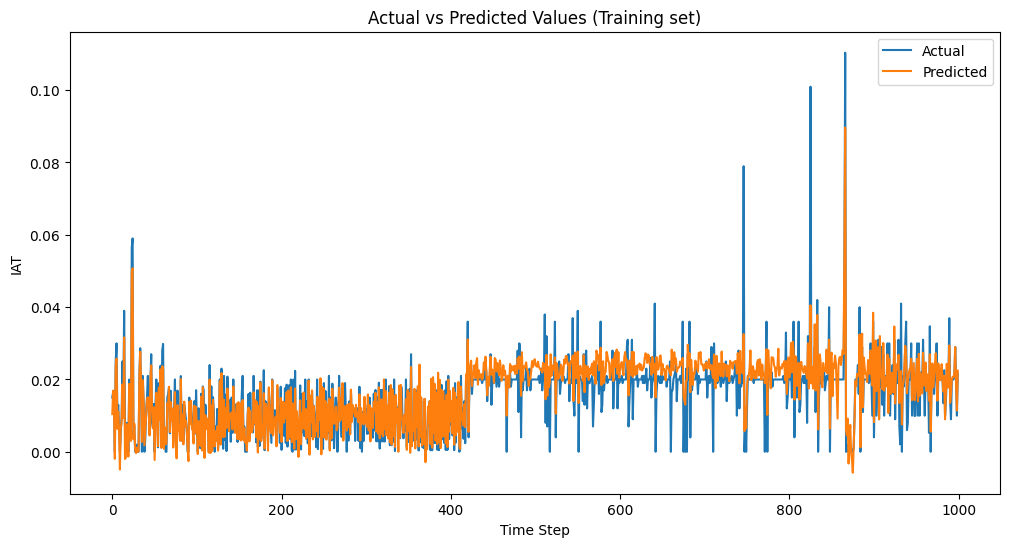

In [11]:
scaler = iat_data_parser.get_minmax_scaler()

# Evaluate the model
cnn.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        # x = x.unsqueeze(0)
        # print("size of X_batch: ", X_batch.size())
        # X_batch = X_batch.transpose(1, 2).contiguous()
        outputs = cnn(X_batch)[0]
        predictions.append(outputs.numpy())
        actuals.append(y_batch.numpy())

predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# print("Predictions: ", predictions)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
# print("actuals size before squeezing: ", actuals.shape)
# actuals = actuals.squeeze(-1)
# print("actuals size: ", actuals.shape)
actuals = scaler.inverse_transform(actuals)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f'Test RMSE: {rmse:.4f}')

# Plot the actual vs predicted values for the first test sample
plt.figure(figsize=(12, 6))
# plt.plot(range(len(actuals[11000])), actuals[0], label='Actual')
# plt.plot(range(len(predictions[11000])), predictions[0], label='Predicted')

plt.plot(range(len(actuals)), actuals, label='Actual')
plt.plot(range(len(predictions)), predictions, label='Predicted')

plt.xlabel('Time Step')
plt.ylabel('IAT')
plt.title('Actual vs Predicted Values (Training set)')
plt.legend()
plt.show()

In [12]:
def persistence_model(inputs):
    """
    Persistence model function that assumes the next value is the same as the last observed value.
    Args:
    - inputs (torch.Tensor): Input tensor of shape (batch_size, seq_len, num_features).

    Returns:
    - torch.Tensor: Output tensor of shape (batch_size, num_features) with the last observed value.
    """
    # Assuming the target is the second feature in the input
    return inputs[:, 0, -1].unsqueeze(1)  # Shape: (batch_size, 1)

In [13]:
def evaluate_model_rmse(dataloader):
    total_loss = 0.0
    total_samples = 0
    all_predictions = []
    all_targets = []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(
            device)  # Ensure data is on the correct device
        predictions = persistence_model(inputs)

        # Collect all predictions and targets for plotting
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

        # Compute the sum of squared errors
        squared_error = F.mse_loss(predictions, targets, reduction='sum')
        total_loss += squared_error.item()
        total_samples += inputs.size(0)

    # Compute the RMSE
    rmse = math.sqrt(total_loss / total_samples)

    # Concatenate all predictions and targets
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return rmse, all_predictions, all_targets


# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming test_loader is defined, replace with your actual DataLoader
# Example DataLoader for test set
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the persistence model on the test set
test_rmse, all_predictions, all_targets = evaluate_model_rmse(test_loader)
print(f'Test RMSE for Persistence Model: {test_rmse:.4f}')

Test RMSE for Persistence Model: 0.1633


Better than persistences


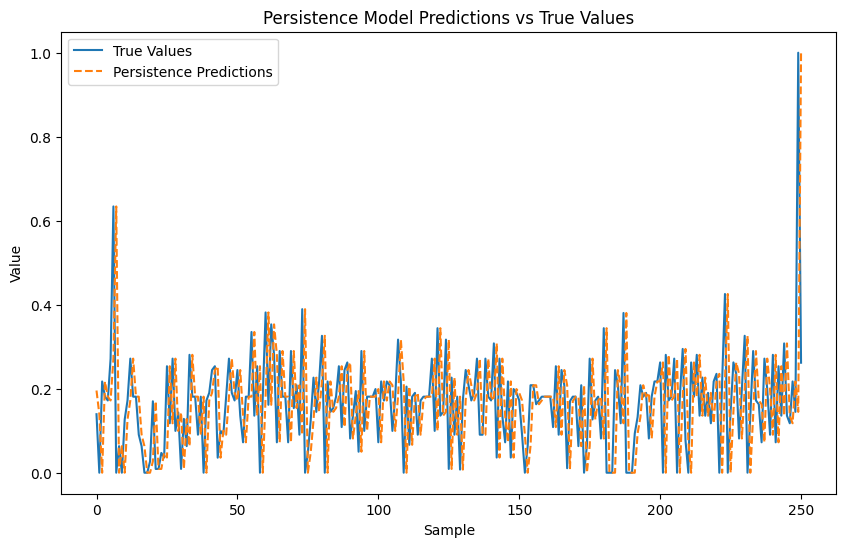

In [14]:
def plot_predictions_vs_true(all_predictions, all_targets):
    plt.figure(figsize=(10, 6))
    plt.plot(all_targets, label='True Values')
    plt.plot(all_predictions, label='Persistence Predictions', linestyle='--')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title('Persistence Model Predictions vs True Values')
    plt.legend()
    plt.show()


if test_rmse > rmse:
    print("Better than persistence")
else:
    print("Equal or worse RMSE than persistence")

# Plot the predictions vs true values
plot_predictions_vs_true(all_predictions, all_targets)